In [1]:
import pandas as pd
import re
import seaborn as sns
import os
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv(r"F:\moseq\Spinal_Cord_Injury-C57BL6\missed_detections.tsv", sep="\t")
df

,Lab,Animal_ID,Session_ID,Fixed?,Needs Re-review?,Problem,Problem Class,Resolution
0,Abraira,20MOS02B,session_20201207131908,False,NaN,something other than the mouse is being tracke...,invalid pixels\r\nblob tracked,NaN
1,Abraira,20MOS10,session_20200814141315,False,NaN,"Mouse is not in frame: 13072-13074, 31659. Fra...",invalid pixels,frames 13072-13074: mouse is just mid-jump - T...
2,Abraira,20MOS10,session_20201005143110,True,NaN,"Frame 32892 looks corrupted, there's a big ban...",invalid pixels,2022-12-19: reprocessed with inpainting of inv...
3,Abraira,20MOS11,session_20200820122140,False,NaN,12965-12966 #something else being detected,blob tracked,NaN
4,Abraira,20MOS22,session_20200916122659,True,Yes,PyTorch failure to open shared event. probably...,memory error,re-ran extraction with no issues
...,...,...,...,...,...,...,...,...
368,Tysseling,NU1_M9,session_20210824115411,False,NaN,28243-28244 #mouse not observed,failure to find ROI,NaN
369,Abraira,21MOS14,session_20210324132821,NaN,NaN,grey dot interfereing for entirety of video ne...,invalid pixels,NaN
370,Hollis,RU13,session_20210520100750,False,NaN,"34671, 34673, 34675 #something else being tracked",invalid pixels,NaN
371,Tysseling,NU1_M17,session_20210819151518,False,NaN,#mouse is there in the bucket but not in the b...,detection failure,NaN


In [27]:
def get_problem_classes(df):
    classes = []
    for i, row in df.iterrows():
        classes.extend(get_problem_classes_for_row(row))
    return list(set(classes))

def get_problem_classes_for_row(row):
    row_classes = str(row['Problem Class']).split('\r\n')
    row_classes = filter(lambda klass: klass not in ['', 'nan'], row_classes)
    return list(set(row_classes))

def has_problem_class(row, klass):
    if isinstance(klass, str):
        klass = [klass]
    row_classes = get_problem_classes_for_row(row)
    return len(set(klass).intersection(set(row_classes))) > 0

def parse_ranges(data):
    matches = re.findall(r"(\d+-\d+)|(\d+)", data)
    results = []
    for m in matches:
        #print(m)
        if m[0] != '':
            parts = [int(k) for k in m[0].split('-')]
            results.extend(list(range(*parts)))
        elif m[1] != '':
            results.append(int(m[1]))
    return results

def sessions_with_problem_classes(df, classes_to_pick):
    sessions = []
    for i, row in df.iterrows():
        if has_problem_class(row, classes_to_pick):
            sessions.append({
                'Lab': row['Lab'],
                'Animal_ID': row['Animal_ID'],
                'Session_ID': row['Session_ID'],
                'Frames': parse_ranges(row['Problem'])
            })
    return sessions

In [8]:
get_problem_classes(df)

['detection failure',
 'unknown',
 'frame rate drop',
 'invalid pixels',
 'no problem',
 'sensor error',
 'blob tracked',
 'failure to find ROI',
 'IR reflection',
 'memory error']

In [9]:
counts = []
for i, row in df.iterrows():
    for klass in get_problem_classes_for_row(row):
        counts.append({
            'Lab': row['Lab'],
            'Animal_ID': row['Animal_ID'],
            'Session_ID': row['Session_ID'],
            'Problem': klass,
            'Num_Frames': len(parse_ranges(row['Problem']))
        })
counts = pd.DataFrame(counts)
counts

,Lab,Animal_ID,Session_ID,Problem,Num_Frames
0,Abraira,20MOS02B,session_20201207131908,invalid pixels,5
1,Abraira,20MOS02B,session_20201207131908,blob tracked,5
2,Abraira,20MOS10,session_20200814141315,invalid pixels,4
3,Abraira,20MOS10,session_20201005143110,invalid pixels,1
4,Abraira,20MOS11,session_20200820122140,blob tracked,1
...,...,...,...,...,...
407,Hollis,RU13,session_20210520100750,invalid pixels,3
408,Tysseling,NU1_M17,session_20210819151518,detection failure,4571
409,Hollis,RU9,session_20210421121235,detection failure,10
410,Hollis,RU9,session_20210421121235,invalid pixels,10


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

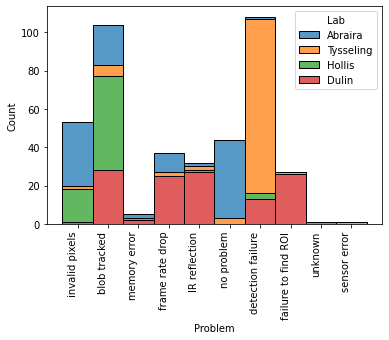

In [10]:
ax = sns.histplot(data=counts, stat='count', multiple="stack", x='Problem', hue='Lab')
plt.xticks(rotation=90, ha='right')

([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

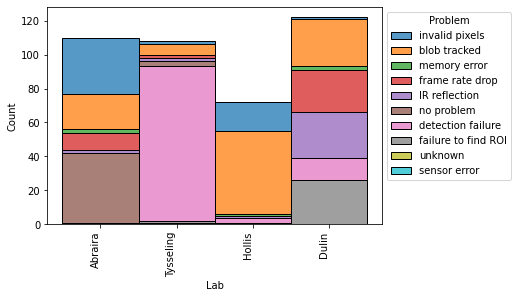

In [11]:
ax = sns.histplot(data=counts, stat='count', multiple="stack", x='Lab', hue='Problem')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90, ha='right')

In [12]:
pd.wide_to_long(pd.pivot_table(counts, values='Num_Frames', index='Problem', columns='Lab', aggfunc='sum'), id_vars=[])

TypeError: wide_to_long() got an unexpected keyword argument 'id_vars'

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Abraira'),
  Text(1, 0, 'Dulin'),
  Text(2, 0, 'Hollis'),
  Text(3, 0, 'Tysseling')])

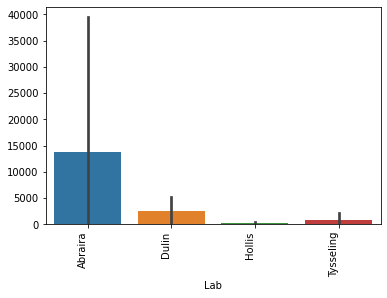

In [13]:
ax = sns.barplot(data=pd.pivot_table(counts, values='Num_Frames', index='Problem', columns='Lab', aggfunc='sum'))
plt.xticks(rotation=90, ha='right')

total frames: 5951
frames (max 25) 721


<AxesSubplot:ylabel='Count'>

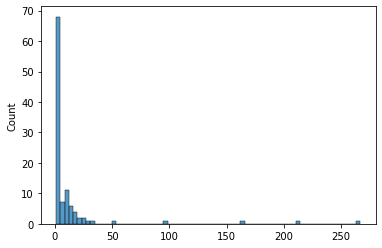

In [31]:
max_frames = 25
sessions = sessions_with_problem_classes(df, ['detection failure'])
print("total frames:", sum([len(s['Frames']) for s in sessions]))
print(f"frames (max {max_frames})", sum([len(s['Frames']) if len(s['Frames']) < max_frames else max_frames for s in sessions]))
sns.histplot([len(s['Frames']) for s in sessions if len(s['Frames']) < 1000])

total frames: 6525
frames (max 25) 501


<AxesSubplot:ylabel='Count'>

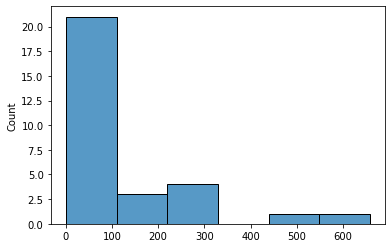

In [32]:
max_frames = 25
sessions = sessions_with_problem_classes(df, ['IR reflection'])
print("total frames:", sum([len(s['Frames']) for s in sessions]))
print(f"frames (max {max_frames})", sum([len(s['Frames']) if len(s['Frames']) < max_frames else max_frames for s in sessions]))
sns.histplot([len(s['Frames']) for s in sessions if len(s['Frames']) < 1000])

total frames: 2422
frames (max 25) 748


<AxesSubplot:ylabel='Count'>

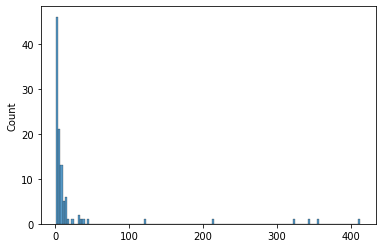

In [33]:
max_frames = 25
sessions = sessions_with_problem_classes(df, ['blob tracked'])
print("total frames:", sum([len(s['Frames']) for s in sessions]))
print(f"frames (max {max_frames})", sum([len(s['Frames']) if len(s['Frames']) < max_frames else max_frames for s in sessions]))
sns.histplot([len(s['Frames']) for s in sessions if len(s['Frames']) < 1000])

total frames: 13798
frames (max 30) 1942
# session over 30: 28
Sessions with no ranges: 2


<AxesSubplot:ylabel='Count'>

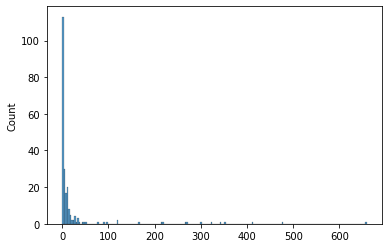

In [61]:
max_frames = 30
sessions = sessions_with_problem_classes(df, ['detection failure', 'IR reflection', 'blob tracked'])
print("total frames:", sum([len(s['Frames']) for s in sessions]))
print(f"frames (max {max_frames})", sum([len(s['Frames']) if len(s['Frames']) < max_frames else max_frames for s in sessions]))
print(f"# session over {max_frames}:", len([s for s in sessions if len(s['Frames']) > max_frames]))
print('Sessions with no ranges:', len([s for s in sessions if len(s['Frames']) == 0]))
sns.histplot([len(s['Frames']) for s in sessions if len(s['Frames']) < 1000])

In [64]:
data_locations = {
    'Abraira': r'H:\Tischfield_Lab_ISI\MoSeq\moseq2\Raw_Data\Abraira_Lab\Spinal_Cord_Injury-C57BL6',
    'Hollis': r'H:\Tischfield_Lab_ISI\MoSeq\moseq2\Raw_Data\Hollis_Lab\SCI-collaboration',
    'Dulin': r'H:\Tischfield_Lab_ISI\MoSeq\moseq2\Raw_Data\Dulin_Lab\moseq-SCI-paper-cohort',
    'Tysseling': r'H:\Tischfield_Lab_ISI\MoSeq\moseq2\Raw_Data\Tysseling_Lab\moseq-sci-paper'
}
output_dir = r"D:\moseq-extract-testing\2023-01-19_new_training_data_from_problem_sessions\detection_failures"

cmds = []
max_frames = 30
num_frames = 0
for s in sessions_with_problem_classes(df, ['detection failure', 'IR reflection', 'blob tracked']):
    # basic command setup
    session_loc = os.path.join(data_locations[s["Lab"]], f'{s["Session_ID"]}.tar.gz')
    cmd = f'moseq-d2-extract generate-dataset {session_loc} --output-label-studio --output-dir {output_dir} --stream depth --stream rgb '
    
    #specific options depending on number of frames
    if  len(s['Frames']) == 0:
        continue
    elif len(s['Frames']) < max_frames:
        cmd += f'--sample-method list --indices {",".join([str(idx) for idx in s["Frames"]])}'
        num_frames += len(s['Frames'])
    else:
        cmd += f'--sample-method kmeans --num-samples {max_frames} --indices {",".join([str(idx) for idx in s["Frames"]])}'
        num_frames += max_frames

    cmds.append(cmd)
cmds
print(num_frames)


1942


In [65]:
with open('dataset_generation_commands.sh', 'w+') as f:
    for cmd in cmds:
        f.write(cmd)
        f.write("\n")